In [3]:
!pip install transformers torch accelerate bitsandbytes
!pip install sootty

  Using cached bitsandbytes-0.46.0-py3-none-manylinux_2_24_x86_64.whl.metadata (10 kB)
Using cached bitsandbytes-0.46.0-py3-none-manylinux_2_24_x86_64.whl (67.0 MB)


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import subprocess
import os
from IPython.display import display, SVG

# --- Configuration ---
MODEL_NAME = "Qwen/Qwen2.5-7B"

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig # <-- Import BitsAndBytesConfig

print(f"Loading tokenizer for '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded successfully.")

# --- Create the 8-bit Quantization Configuration ---
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

print("\nLoading model with 8-bit quantization... This will take time and memory.")
try:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="cuda",
        # Pass the config object instead of the old argument
        quantization_config=quantization_config,
    )
    print("✅ Model loaded successfully into memory!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("\nThis likely means your system (GPU + RAM) is out of memory.")

Loading tokenizer for 'Qwen/Qwen2.5-7B'...
Tokenizer loaded successfully.

Loading model with 8-bit quantization... This will take time and memory.


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Model loaded successfully into memory!


In [4]:
def generate_verilog_locally(prompt, tokenizer, model):
    """
    Generates Verilog code using the loaded local model.
    """
    print(f"Generating code for prompt: '{prompt[:30]}...'")
    try:
        # Encode the prompt text into tokens
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        # Generate output tokens from the model
        outputs = model.generate(**inputs, max_new_tokens=8096, pad_token_id=tokenizer.eos_token_id)
        
        # Decode the tokens back to text, skipping special tokens
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Clean up the output
        if generated_text.startswith(prompt):
            return generated_text[len(prompt):].strip()
        return generated_text.strip()

    except Exception as e:
        print(f"Error during local model inference: {e}")
        return None


In [5]:
module_name = 'mux_4to1'
design_filename = f"{module_name}.v"
testbench_filename = f"{module_name}_tb.v"

# --- Generate Design ---
design_prompt = f"Generate the Verilog code for a {module_name}."
design_code = generate_verilog_locally(design_prompt, tokenizer, model)

print("\n--- Generated Verilog Design ---")
print(design_code)
with open(design_filename, "w") as f:
    f.write(design_code)
print(f"Saved design to {design_filename}")

Generating code for prompt: 'Generate the Verilog code for ...'


/home/irman/anaconda3/envs/llm_env/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(



--- Generated Verilog Design ---
The mux_4to1 should have four inputs (a,b,c,d) and one output (y). The output should be equal to the input selected by the two-bit select signal (s). The select signal should be able to select any of the four inputs. The Verilog code for a mux_4to1 is as follows:

```verilog
module mux_4to1 (
    input [3:0] a, b, c, d,
    input [1:0] s,
    output reg y
);

always @ (s or a or b or c or d) begin
    case (s)
        2'b00: y = a;
        2'b01: y = b;
        2'b10: y = c;
        2'b11: y = d;
    endcase
end

endmodule
```

In this code, the module `mux_4to1` takes four inputs `a`, `b`, `c`, and `d`, and a two-bit select signal `s`. The output `y` is the selected input based on the select signal. The `always` block with the `case` statement selects the appropriate input based on the select signal. The `reg` keyword is used to declare the output `y` as a register.
Saved design to mux_4to1.v


In [ ]:
testbench_prompt = f"""Generate a comprehensive Verilog testbench for the following module named '{module_name}'.
Ensure the testbench correctly instantiates the module, connects to all of its ports, and provides meaningful stimulus to verify its functionality.
Don't forget to add `timescale 1ns/100ps directive at the top of the testbench.
Here is the Verilog code for the module to be tested:
```verilog
{design_code}"""

testbench_code = generate_verilog_locally(testbench_prompt, tokenizer, model)

print("\n--- Generated Verilog Testbench ---")
print(testbench_code)
with open(testbench_filename, "w") as f:
    f.write(testbench_code)
print(f"Saved testbench to {testbench_filename}")


--- Running Simulation ---
Compiling mux_4to1.v and mux_4to1_tb.v...
Simulating...
Simulation successful. Found waveform file: mux_4to1_tb.vcd

--- Displaying Waveform from mux_4to1_tb.vcd using sootty library ---
Saving waveform to mux_4to1_tb.svg...
Save successful.
Displaying waveform:


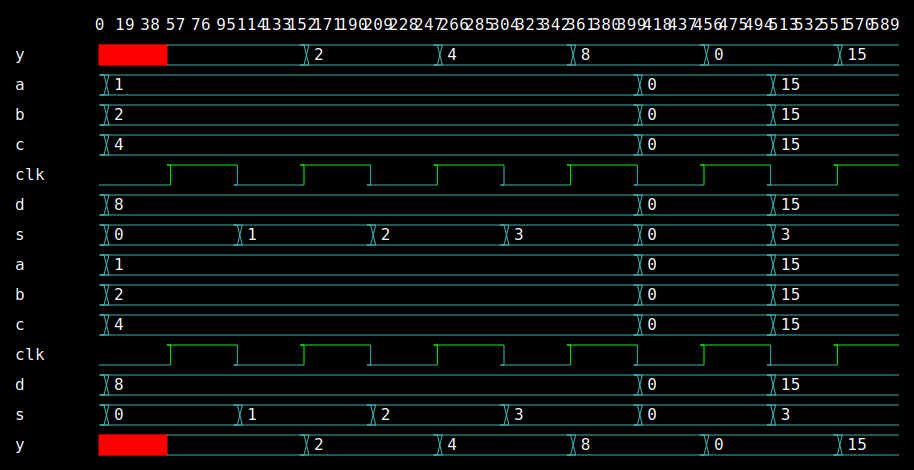

In [24]:
import subprocess
import os
from IPython.display import display, SVG
# Import the required sootty library components
from sootty import WireTrace, Visualizer, Style

def run_simulation(design_file, testbench_file):
    """
    Compiles and runs a Verilog simulation with iverilog.
    """
    base_name = os.path.splitext(testbench_file)[0]
    output_file = f"{base_name}_sim"
    vcd_file = f"{base_name}.vcd"
    
    compile_command = ["iverilog", "-o", output_file, design_file, testbench_file]
    run_command = ["vvp", output_file]
    
    print("\n--- Running Simulation ---")
    try:
        print(f"Compiling {design_file} and {testbench_file}...")
        subprocess.run(compile_command, capture_output=True, text=True, check=True)
        
        print("Simulating...")
        subprocess.run(run_command, capture_output=True, text=True, check=True)
        
        if os.path.exists(vcd_file):
            print(f"Simulation successful. Found waveform file: {vcd_file}")
            return vcd_file
        else:
            print(f"Error: Simulation ran, but the expected VCD file '{vcd_file}' was not created.")
            return None
            
    except subprocess.CalledProcessError as e:
        print(f"Error during simulation step:")
        print(e.stderr)
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

def display_waveform_notebook(vcd_file):
    """
    Uses the sootty Python library to parse a VCD file, render it as an SVG,
    and display it directly in the notebook while also saving a copy.
    """
    if not vcd_file:
        print("Cannot display waveform, no VCD file provided.")
        return

    svg_file = os.path.splitext(vcd_file)[0] + ".svg"
    print(f"\n--- Displaying Waveform from {vcd_file} using sootty library ---")

    try:
        # Create a WireTrace object from the VCD file.
        wiretrace = WireTrace.from_vcd(vcd_file)

        # Convert the wiretrace to an SVG image object.
        image = Visualizer(Style.Dark).to_svg(wiretrace)

        # Save the SVG to a file.
        print(f"Saving waveform to {svg_file}...")
        with open(svg_file, "w") as f:
            f.write(str(image))
        print("Save successful.")

        # CORRECTED: Display the image from the saved SVG file.
        print("Displaying waveform:")
        display(SVG(filename=svg_file))

    except Exception as e:
        print(f"An error occurred while displaying the waveform: {e}")


# --- How to run the final code ---
vcd_file_result = run_simulation("mux_4to1.v", "mux_4to1_tb.v")

if vcd_file_result:
    display_waveform_notebook(vcd_file_result)
else:
    print("\nSkipping waveform display due to simulation failure or missing VCD file.")

In [30]:
import os
import json
import shutil
import subprocess

# --- Configuration ---
DESIGN_NAME = "mem_1r1w"
SOURCE_VERILOG_FILE = "mem_1r1w.v" 

# --- Dynamic Paths ---
HOME_DIR = os.path.expanduser("~")
OPENLANE_DIR = os.path.join(HOME_DIR, "OpenLane")
# Use the specific docker image you provided for consistency
OPENLANE_IMAGE = "efabless/openlane:e73fb3c57e687a0023fcd4dcfd1566ecd478362a-amd64"

DESIGN_DIR = os.path.join(OPENLANE_DIR, "designs", DESIGN_NAME)
SRC_DIR = os.path.join(DESIGN_DIR, "src")

# --- OpenLane Configuration JSON ---
config = {
    "DESIGN_NAME": "mem_1r1w",
    "VERILOG_FILES": "dir::src/*.v",
    "CLOCK_PORT": "clk",
    "CLOCK_PERIOD": 10.0,
    "DESIGN_IS_CORE": "false",
    "FP_PDN_CORE_RING": "false",
    "RT_MAX_LAYER": "met4"
}

def run_command(command, working_dir):
    """A generic helper function to run a command and print its output."""
    print(f"\n--- Running Command: `{' '.join(command)}` in `{working_dir}` ---")
    try:
        result = subprocess.run(
            command,
            cwd=working_dir,
            check=True,
            capture_output=True,
            text=True
        )
        print("STDOUT:")
        print(result.stdout)
        if result.stderr:
            print("STDERR:")
            print(result.stderr)
        print("--- Command Successful ---")
        return True
    except subprocess.CalledProcessError as e:
        print(f"--- Error running command: {' '.join(e.cmd)} ---")
        print(f"Return Code: {e.returncode}")
        print("STDOUT:")
        print(e.stdout)
        print("STDERR:")
        print(e.stderr)
        return False
    except FileNotFoundError:
        print(f"--- Error: Command not found. Make sure '{command[0]}' is installed and in your PATH. ---")
        return False

def main():
    """Main function to set up and run the OpenLane flow."""
    print(f"Starting OpenLane flow for design: {DESIGN_NAME}")

    # Steps 1-4: Set up the design directory, config, and Verilog file
    if not os.path.exists(SOURCE_VERILOG_FILE):
        print(f"Error: Source Verilog file not found at '{SOURCE_VERILOG_FILE}'")
        return
    print(f"Creating directory: {SRC_DIR}")
    os.makedirs(SRC_DIR, exist_ok=True)
    config_path = os.path.join(DESIGN_DIR, "config.json")
    print(f"Creating config file: {config_path}")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)
    dest_verilog_path = os.path.join(SRC_DIR, os.path.basename(SOURCE_VERILOG_FILE))
    print(f"Copying '{SOURCE_VERILOG_FILE}' to '{dest_verilog_path}'")
    shutil.copy(SOURCE_VERILOG_FILE, dest_verilog_path)

    # Step 5: Construct and run the single, non-interactive Docker command
    print("--- Preparing to run OpenLane flow ---")
    
    # This single command starts the container and immediately runs the flow inside it.
    # It combines your docker command logic with the flow execution command.
    docker_command = [
        'docker', 'run', '--rm',
        '-v', f'{HOME_DIR}:{HOME_DIR}',
        '-v', f'{OPENLANE_DIR}:/openlane',
        '-e', f'PDK_ROOT=/home/irman/.volare', # Hardcoded from your example for consistency
        '-e', 'PDK=sky130A',
        '--user', f'{os.getuid()}:{os.getgid()}',
        OPENLANE_IMAGE,
        './flow.tcl',
        '-design', DESIGN_NAME
    ]
    
    if not run_command(docker_command, working_dir=OPENLANE_DIR):
        print("\nOpenLane flow failed. Check the errors above.")
        return
        
    print(f"\n✅ OpenLane flow for {DESIGN_NAME} completed successfully!")
    print(f"You can find the results in: {DESIGN_DIR}/runs/")

if __name__ == "__main__":
    main()

Starting OpenLane flow for design: mem_1r1w
Creating directory: /home/irman/OpenLane/designs/mem_1r1w/src
Creating config file: /home/irman/OpenLane/designs/mem_1r1w/config.json
Copying 'mem_1r1w.v' to '/home/irman/OpenLane/designs/mem_1r1w/src/mem_1r1w.v'
--- Preparing to run OpenLane flow ---

--- Running Command: `docker run --rm -v /home/irman:/home/irman -v /home/irman/OpenLane:/openlane -e PDK_ROOT=/home/irman/.volare -e PDK=sky130A --user 1000:1000 efabless/openlane:e73fb3c57e687a0023fcd4dcfd1566ecd478362a-amd64 ./flow.tcl -design mem_1r1w` in `/home/irman/OpenLane` ---
STDOUT:
OpenLane v1.1.1 (e73fb3c57e687a0023fcd4dcfd1566ecd478362a)
All rights reserved. (c) 2020-2024 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'designs/mem_1r1w/config.json'...
[INFO]: Process Design Kit: sky130A
[INFO]: PDK Root: /home/irman/.volare
[INFO]: Standard Cell Library: sky130_fd_sc_hd
